# ECE 157A/272A Fall 2022 Homework 2

Name: Jackson Newman

In [26]:
import os
import typing
from typing import Tuple

import numpy as np
import pandas as pd

# OpenCV and Scikit-Image for image manipulation 
import cv2
from skimage.transform import resize
from skimage.measure import label, regionprops, perimeter
import math

# Seaborn and Matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-Learn Descision Tree and helper functions
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, homogeneity_score, completeness_score

FAIL = 2 # failing die
PASS = 1 # passing die
NO_DIE = 0 # no die
RANDOM_SEED = 10

### Helper Functions

In [5]:
# TODO: Implement a function that takes a wafer map and outputs it to a directory with the given name
def output_image(wafer_map: np.ndarray, name: str, dir: str, vmin: int=0, vmax: int=2) -> None:
    # use os library to check whether directory exists
    # if not, make the directory
    # CODE HERE
    if not os.path.isdir(dir):
        os.mkdir(dir)
    # use plt.imsave to save wafer_map under the given directory with the given name
    # note: set the min value (vmin) and max vlaue (vmax) for plt.imsave based on wafer map value range
    # CODE HERE
    os.chdir(dir)
    plt.imsave(name, wafer_map, format='png', vmin=0, vmax=2)
    os.chdir('..')
    
    return

# TODO: Implement a function that outputs all wafer maps to corresponding failure type directories
def output_all_wafer_maps(df: pd.DataFrame) -> None:
    # iterate through all rows in the dataframe with df.iterrows()
    # From the row, get wafer map, failure type, lot name and wafer index
    # output wafer map as "<failure type dir>/<lot name>-<wafer index>.png"
    # CODE HERE
    for index, row in df.iterrows():
        waferMap = row["waferMap"]
        failureType = row["failureType"]
        name = row["lotName"]
        waferIndex = row["waferIndex"]
        output_image(waferMap, name+'-'+str(waferIndex), failureType)

    return


In [6]:
# TODO: Implement a function that generate a single plot showing one wafer map example from each failure type
def visualize_failure_types(df: pd.DataFrame, figsize=(16,9)) -> None:
    # Find unique failure types within the "failureType" column of the df
    # CODE HERE
    failTypes = []
    for index, row in df.iterrows():
        if failTypes.count(row["failureType"]) == 0:
            failTypes.append(row["failureType"])
    # Create plt canvas with 6 subplots (2 rows and 3 columns) with plt.subplots
    # CODE HERE
    plt.figure(figsize=(16, 9))
    # iterate through all the classes and show one wafer map per class
    # CODE HERE
    for i in range(1,6):
        for index, row in df.iterrows():
        # Pick the first image from each category
        # hint: search for select pandas row based on conditions
        # and dataframe indexing
        # CODE HERE
            failureType = row["failureType"]
            name = row["lotName"]
            waferIndex = row["waferIndex"]
            plt.subplot(2,3,i)
            # Plt image on the axes
            # CODE HERE
            if failureType == failTypes[i-1]:
                plt.imshow(row["waferMap"])
                break;
    
    # show your plot
    plt.show()


### Load Dataset

In [7]:
# load training dataset as pandas dataframe
np_train = np.load('wafermap_train.npy', allow_pickle=True)
df_train = pd.DataFrame.from_records(np_train)


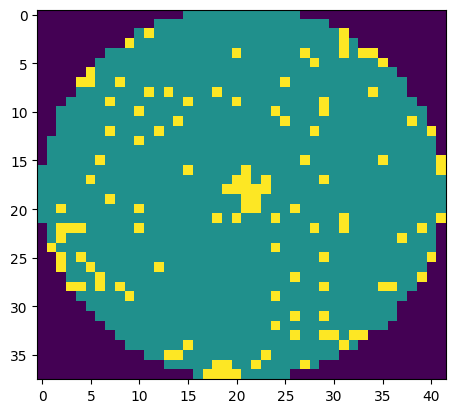

In [8]:
plt.imshow(df_train.at[1,"waferMap"])


### Dataset Inspection

In [9]:
# use pandas to inspect the dataset information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1693 entries, 0 to 1692
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           1693 non-null   int64  
 1   dieSize         1693 non-null   float64
 2   failureType     1693 non-null   object 
 3   lotName         1693 non-null   object 
 4   trainTestLabel  1693 non-null   object 
 5   waferIndex      1693 non-null   float64
 6   waferMap        1693 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 92.7+ KB


In [10]:
# inspect the dieSize
# notice that the die size varies? 
# We will need to preprocess them to make it uniform 
df_train['dieSize'].value_counts()

1334.0    297
1226.0    145
2393.0     99
1080.0     77
1389.0     68
         ... 
2071.0      1
7870.0      1
4014.0      1
2268.0      1
1791.0      1
Name: dieSize, Length: 205, dtype: int64

<AxesSubplot: >

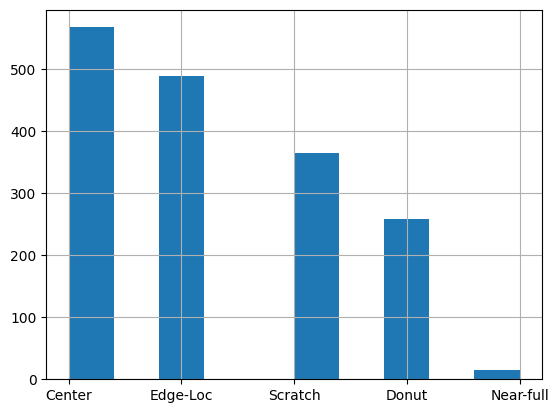

In [11]:
# inspect the failure types and the distributions
df_train['failureType'].hist()

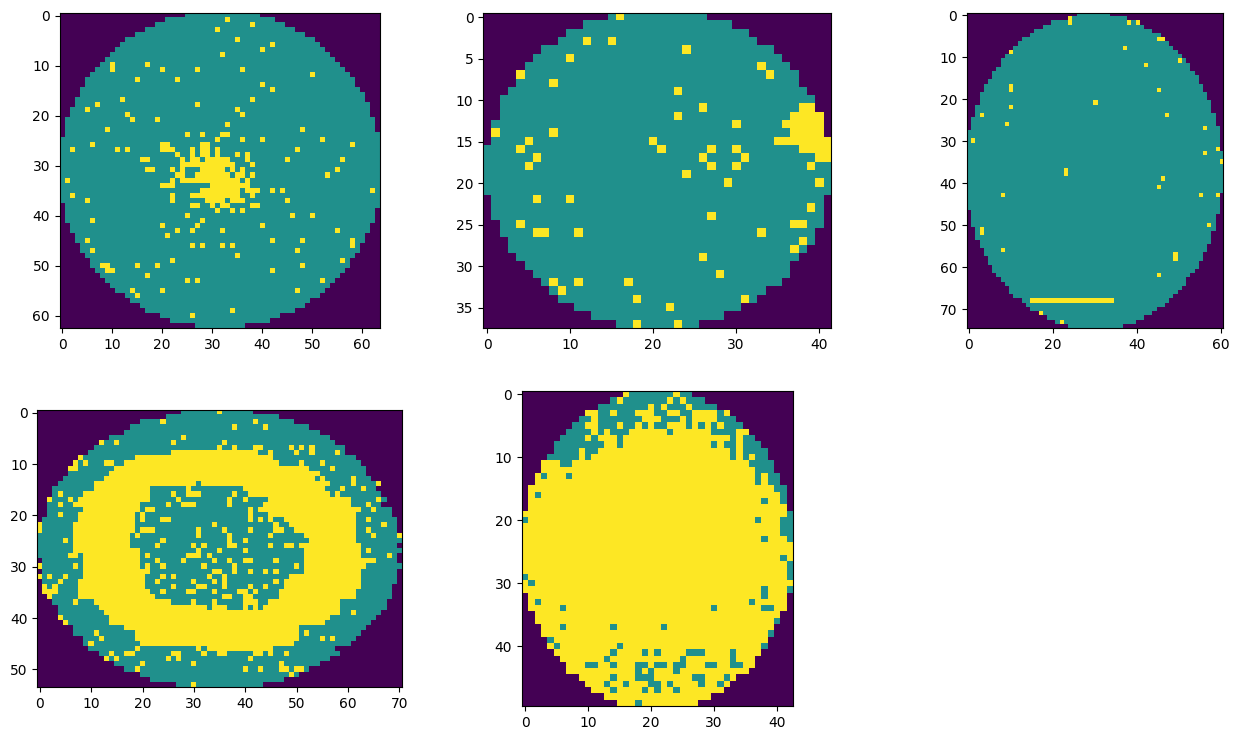

In [12]:
# show a wafermap in each class
visualize_failure_types(df_train)

In [13]:
# output all images to failure type directory
root_dir = 'defect_types'
output_all_wafer_maps(df_train)

### Data Preparation (Part 1)

For data preparation, we need to perform the following operations:
1) Resize the wafer maps as a numpy array of shape [x, 64, 64]
2) Convert the labels into numeric values

In [14]:
# TODO: The function takes the failure type string 
# and returns the numeric value of failureType
def convert_failure_type(failure_type: str) -> int:
    # Create dictionary for converting string to numeric number
    string2int = {# CODE HERE
        "Center" : 1,
        "Edge-Loc" : 2,
        "Scratch" : 3,
        "Donut" : 4,
        "Near-full" : 5
    }

    return string2int[failure_type]

# TODO: The function resizes a wafer to specified output shape using opencv's resize function
def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple=(64, 64)) -> np.ndarray:
    # CODE HERE
    resized_wafer_map = cv2.resize(wafer_map,output_shape)
    
    return resized_wafer_map

# create dataframe columns to store the return values of the two tasks below:
#       (1) reshapes the wafer maps as a numpy array of shape (64, 64), 
#       (2) and converts the failureType into numeric values 
def prepare_data(df: pd.DataFrame, has_labels: bool=True) -> Tuple[np.ndarray, list]:
    # Resize_wafer_map function to resize the wafer map to a larger size
    # note: here we decided to overwrite the waferMap column, but for best
    # practice, it's best to create a new column unless you don't need the original
    # wafer map data anymore
    df['waferMap'] = df['waferMap'].apply(resize_wafer_map) 
    if(has_labels):
        df['failureTypeInt'] = df['failureType'].apply(convert_failure_type)

    return df

Prepare the data with the above function

In [15]:
# actually resizing the wafer map and converting failure types
# in the training dataframe
df_train = prepare_data(df_train)

### Feature Engineering
Extract features from the wafer maps

In [32]:
# The function that detects connect components using skimage
# and selects one with the largest area which we call salient region
# TODO: skip to the create_feature_columns code block and generate salient region
# before proceeding to other feature extractor functions
# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
# https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
def get_salient_region(row: pd.Series) -> np.ndarray:
    # get wafer map from dataframe row
    wafer_map = row['waferMap']

    # create a wafer map with NO_DIE as background and FAIL as defect
    failure_only = np.zeros_like(wafer_map)
    failure_only[wafer_map==FAIL] = FAIL

    # label the connected components and get their regions properties
    # note: you might want to plot the labeled_image to take a look at the 
    # return of the label function
    labeled_image = label(failure_only, background=NO_DIE, connectivity=2)
    region_props = regionprops(labeled_image)

    # returns the largest connected component as salient region
    # note: label image starts connected component label at value 1 with background being 0
    # thus, we need to add 1 after argmax
    largest_region_label = np.argmax([prop.area for prop in region_props]) + 1
    salient_region = np.zeros_like(labeled_image)
    salient_region[labeled_image == largest_region_label] = FAIL

    # # uncomment to verify the salient region
    #fig, ax = plt.subplots(nrows=1, ncols=2)
    #ax[0].imshow(wafer_map)
    #ax[1].imshow(salient_region)
    #plt.show()

    return salient_region

# TODO: The function returns the ratio of the area of the salient region to the area of the wafer map
def get_area_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # count the number of fail dice on salient region
    # count the total number of dice on wafer map
    # divide them to get area_ratio
    # CODE HERE
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    waferArea = waferRegions[0].area
    
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)
    salientArea = salientRegions[0].area
    area_ratio = salientArea/waferArea
    return area_ratio

# TODO: The function returns the ratio of the perimeter of the salient region to the radius of the wafer map
def get_perimeter_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # label the salient region connected components and get their regions properties
    # CODE HERE
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)
    # find perimeter and wafer map radius
    # CODE HERE
    perimeter = salientRegions[0].perimeter
    waferMapRadius = 32
    # divide them to get ratio
    # CODE HERE
    perimeter_ratio = perimeter/waferMapRadius
    return perimeter_ratio

# TODO: The function returns the maximal distance between the salient region and 
# the center of the wafer map
def get_max_dist_from_center(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # find center of the wafer map
    # CODE HERE
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)
   
    waferCenter = waferRegions[0].centroid
    salientCoordinates = salientRegions[0].coords
    # get all coordinates of the salient region and compute the max distance
    # from center
    # CODE HERE
    max_distance = 0
    for coordinates in salientCoordinates:
        distance = math.sqrt((waferCenter[0] - coordinates[0])**2 + (waferCenter[1] - coordinates[1])**2)
        if distance > max_distance:
            max_distance = distance

    return max_distance

# TODO: The function returns the minimal distance between the salient region and 
# the center of the wafer map
def get_min_dist_from_center(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # find center of the wafer map
    # CODE HERE
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # find center of the wafer map
    # CODE HERE
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)

    waferCenter = waferRegions[0].centroid
    salientCoordinates = salientRegions[0].coords

    # get all coordinates of the salient region and compute the min distance
    # from center
    # CODE HERE
    min_distance = 64
    for coordinates in salientCoordinates:
        distance = math.sqrt(
            (waferCenter[0] - coordinates[0])**2 + (waferCenter[1] - coordinates[1])**2)
        if distance < min_distance:
            min_distance = distance

    return min_distance

# TODO: The function returns the ratio of the length of the major axis of the estimated 
# ellipse surrounding the salient region to the radius of the wafer map
def get_major_axis_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # label the salient region connected components and get their regions properties
    # CODE HERE
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)
    
    waferRadius = 32
    salientMajorAxis = salientRegions[0].major_axis_length

    # find major axis and wafer map radius
    # CODE HERE
    major_axis_ratio = salientMajorAxis/waferRadius
    
    return major_axis_ratio

# TODO: The function returns the ratio of the length of the minor axis of the estimated 
# ellipse surrounding the salient region to the radius of the wafer map
def get_minor_axis_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # label the salient region connected components and get their regions properties
    # CODE HERE
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)

    waferRadius = 32
    salientMinorAxis = salientRegions[0].minor_axis_length

    # find minor axis and wafer map radius
    # CODE HERE
    minor_axis_ratio = salientMinorAxis/waferRadius

    return minor_axis_ratio

#TODO: The function returns the solidity, indicating the proportion of defective dice
# in the estimated convex hull of the salient region
def get_solidity(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # label the salient region connected components and get their regions properties
    # CODE HERE
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)
    # get solidity of salient region
    # CODE HERE
    solidity = salientRegions[0].solidity

    return solidity

# TODO: The function returns the eccentricity of the salient region
def get_eccentricity(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # label the salient region connected components and get their regions properties
    # CODE HERE
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)
    # get eccentricity of salient region
    # CODE HERE
    eccentricity = salientRegions[0].eccentricity
    
    return eccentricity

# TODO: The function returns the ratio of the failed dice on the wafer map to the total 
# number of dice on the wafer map
def get_yield_loss(row: pd.Series) -> float:
    # retrieve wafer map
    # CODE HERE
    wafer_map = row["waferMap"]
    # count FAIL dice and total number of dice
    # CODE HERE
    fails = np.sum(wafer_map == 2)
    print(fails)
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    waferArea = waferRegions[0].area

    # compute yield loss
    # CODE HERE
    yield_loss = fails/waferArea
    
    return yield_loss

# TODO: The function returns the ratio of the failed dice on the outermost two rings of the 
# wafer map to the total number of dice on the outermost two rings of the wafer map
def get_edge_yield_loss(row: pd.Series) -> float:
    # retrieve wafer map
    # CODE HERE
    wafer_map = row["waferMap"]
    # find ring label that highlights the outermost two rings of the wafer
    # CODE HERE
    outermostTwoRings = ring_label_from_outside(wafer_map)
    # get edge FAIL dice and total number of edge dice
    # CODE HERE
    fails = np.sum(outermostTwoRings == 2)
    total = np.sum(outermostTwoRings >= 1)

    return edge_yield_loss


# TODO: This helper function returns return an numpy array highlighting the outermost two rings
# of the wafer map with nonzero value
def ring_label_from_outside(wafer_map: np.ndarray) -> np.ndarray:
    # CODE HERE use erode function
    ring_labels = np.array()
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    waferCoordinates = waferRegions[0].coords
    for coordinates in waferCoordinates:
        distance = math.sqrt(
            (waferCenter[0] - coordinates[0])**2 + (waferCenter[1] - coordinates[1])**2)
        if distance >= 31:
            ring_labels.append(coordinates)

    return ring_labels
            


In [33]:
# # uncomment to use test codes for feature extractor functions
failure_type = 'Center'
row_index = 0
row = df_train.loc[df_train['failureType']==failure_type].iloc[row_index]


# print(get_salient_region(row))
# print(get_area_ratio(row))
print(get_max_dist_from_center(row))
print(get_min_dist_from_center(row))
# print(get_perimeter_ratio(row))
# print(get_major_axis_ratio(row))
# print(get_minor_axis_ratio(row))
# print(get_solidity(row))
# print(get_eccentricity(row))
print(get_yield_loss(row))
print(get_edge_yield_loss(row))

12.828719295278258
0.3611307448412432
243
0.08057029177718833


TypeError: array() missing required argument 'object' (pos 0)

In [18]:
# This function applies all feature extractor functions onto the 
# dataframe and save the results to new columns
def create_feature_columns(df: pd.DataFrame) -> pd.DataFrame:
    # format df['<new column name>'] = df.apply(<feature extractor function>, axis=1)
    df['salientRegion'] = df.apply(get_salient_region, axis=1)
    # TODO: fill in the rest of the feature extractor functions using same format
    # CODE HERE
    df['areaRatio'] = df.apply(get_area_ratio, axis=1)
    df['maxDistFromCenter'] = df.apply(get_max_dist_from_center, axis=1)
    df['minDistFromCenter'] = df.apply(get_min_dist_from_center, axis=1)
    df['perimeterRatio'] = df.apply(get_perimeter_ratio, axis=1)
    df['majorAxisRatio'] = df.apply(get_major_axis_ratio, axis=1)
    df['minorAxisRatio'] = df.apply(get_minor_axis_ratio, axis=1)
    df['solidity'] = df.apply(get_solidity, axis=1)
    df['eccentricity'] = df.apply(get_eccentricity, axis=1)
    df['yieldLoss'] = df.apply(get_yield_loss, axis=1)
    df['edgeYieldLoss'] = df.apply(get_edge_yield_loss, axis=1)

    return df

In [31]:
# actually applying the feature extractors on the training dataframe
df_train = create_feature_columns(df_train)

243
296
115
148
177
116
101
136
63
61
247
294
178
162
129
120
80
107
99
49
94
112
117
67
128
228
236
394
220
173
90
68
87
88
72
71
51
389
132
160
122
313
230
186
254
228
397
242
271
240
321
201
192
190
213
142
157
225
252
289
329
243
331
262
276
225
120
116
76
112
144
225
191
171
185
186
158
140
136
173
81
118
322
164
306
313
304
322
405
316
252
192
477
185
242
240
182
134
70
154
777
1042
1220
423
200
1305
1085
555
863
466
1313
1207
1112
301
1599
1842
2216
1208
1694
1470
1404
2180
1612
2124
1288
1701
651
438
1449
1843
322
1840
1035
521
731
479
432
1072
528
1729
1830
1759
563
385
977
998
1083
435
693
284
498
2186
1443
1541
512
1142
686
842
1161
789
712
795
2016
1815
2011
2300
2268
496
491
1502
491
1631
1321
2089
1904
1316
2103
1276
1595
1792
1127
1274
1343
1289
1344
1988
1249
1539
1442
1556
1105
283
320
241
90
158
616
323
180
145
1943
2058
235
189
136
1387
447
218
203
610
840
701
561
311
227
609
421
1586
1301
1588
64
151
1222
1877
1381
1625
1586
1721
1936
974
1722
1235
1710
1355
1687
11

NameError: name 'ring_labels' is not defined

### Data Preparation (Part 2)

prepare the dataset for training models

In [ ]:
# TODO: From the dataframe select the features we extracted as X 
# and y is the numerical failure type labels
# CODE HERE

# TODO: split dataset into training and validation set
# we will set aside some portion of the training data as validation data
# CODE HERE


In [ ]:
# check train/validation distribution
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
y_train.hist()
plt.title('Training Label Distribution')

plt.subplot(1,2,2)
y_valid.hist()
plt.title('Validation Label Distribution')

plt.show()

Train and Evaluate a Decision Tree Model

In [ ]:
# TODO: initialize Decision Tree classifier with max tree depth of 3
# CODE HERE

# TODO: Train the Decision Tree classifier with the training data
# CODE HERE

In [ ]:
# TODO: Implement a function that calculates the prediction accuracy.
def calculate_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):
    # CODE HERE
    return accuracy

# TODO: Implement a function that calculates the prediction acuuracy for each failure type.
def calculate_per_class_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):
    # CODE HERE
    return accuracies

In [ ]:
# TODO: get the predicted labels of the training data and calculate the accuracy
# CODE HERE
print(f'Model accuracy on training data set is {acc_train:.2f}%')

# TODO: calculate the accuracy for each failure type
# CODE HERE
print(f'Model accuracy on training data set for each class is {accuracies_train}%')

# TODO: get failure types string sorted by their numerical value
tick_labels = # CODE HERE

# TODO: compute confusion matrix and assign labels parameter
cm = # CODE HERE

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=tick_labels , 
            yticklabels=tick_labels,
            cmap='Blues')

# TODO: provide x-axis label and y-axis label
plt.xlabel(# CODE HERE)
plt.ylabel(# CODE HERE)

# show plot
plt.show()

In [ ]:
# TODO: get the predicted labels of the validation data and calculate the accuracy
# CODE HERE
print(f'Model accuracy on validation data set is {acc_valid:.2f}%')

# TODO: calculate the accuracy for each failure type
# CODE HERE
print(f'Model accuracy on validation data set for each class is {accuracies_valid}%')

# TODO: get failure types string sorted by their numerical value
tick_labels = # CODE HERE

# TODO: compute confusion matrix and assign labels parameter
cm = # CODE HERE

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=tick_labels, 
            yticklabels=tick_labels,
            cmap='Blues')

# TODO: provide x-axis label and y-axis label
plt.xlabel(# CODE HERE)
plt.ylabel(# CODE HERE)

# show plot
plt.show()

In [ ]:
# TODO: get failure types string sorted by their numerical value
class_names = # CODE HERE

# plot decision tree
plt.figure(figsize=(18,12))
tree.plot_tree(classifier,                              # classifier to extract the rules from
                feature_names=selected_features,        # the feature names that were used
                class_names=class_names,                # the class labels, converted to string
                filled=True, fontsize=6)
plt.show()

### Testing Set

Data Loading, Preprocess, and Feature Extraction

In [ ]:
# TODO: load test dataset with pandas from wafermap_test.npy
# CODE HERE

# TODO: apply data preparation function
# note: test data does not have failureType column
# CODE HERE

# TODO: apply feature exatractors to extract features
# CODE HERE

Generate Predictions for the Test Set

In [ ]:
# TODO: From the dataframe select the features we extracted as X 
# and y is the numerical failure type labels
# CODE HERE

# TODO: get the predicted labels of the test data and convert them back to string
# and output as scores.csv
# CODE HERE